<a href="https://colab.research.google.com/github/mnhall3/COSC210/blob/main/SmoothingAndInterpolating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount drive - super ez

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Mounted at /content/drive


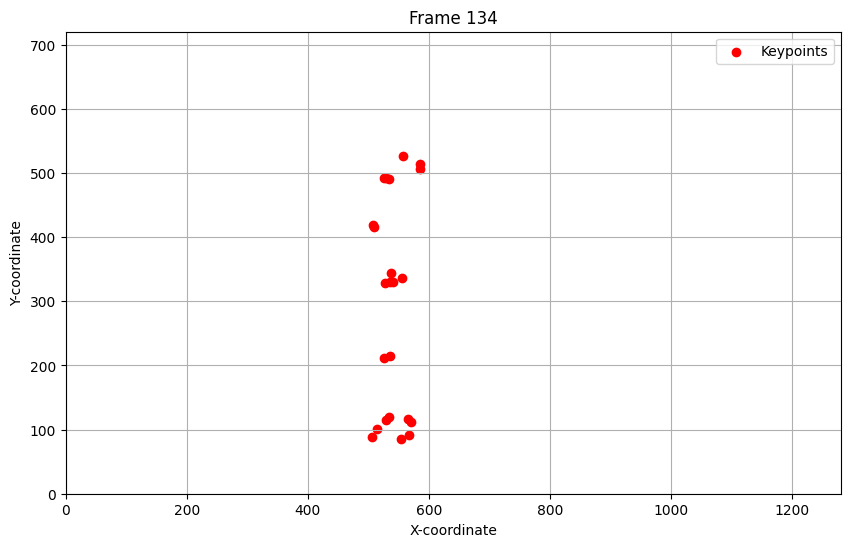

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2

# Function to load keypoints from .npy files
def load_keypoints_from_npy(input_folder):
    keypoints_list = []
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith(".npy"):
            file_path = os.path.join(input_folder, file_name)
            keypoints = np.load(file_path)
            keypoints_list.append(keypoints)
    return np.array(keypoints_list)

# Load keypoints
input_folder = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.33/Output_NoArms_.33Max_T2_Corrected'
keypoints = load_keypoints_from_npy(input_folder)

# Load reference video to get dimensions and duration
reference_video_path = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/AllVideoFiles/ProcessedAVIs/NoArms_.33Max_T2.avi'
cap = cv2.VideoCapture(reference_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
ret, frame = cap.read()
if ret:
    image_height, image_width, _ = frame.shape
cap.release()

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, image_width)
ax.set_ylim(0, image_height)
scat = ax.scatter([], [], c='r', marker='o', label='Keypoints')
ax.set_title('Keypoints Plot')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.legend()
ax.grid(True)

# Function to update the scatter plot with keypoints for each frame
def update(frame):
    x_coordinates = keypoints[frame, :, 0]
    y_coordinates = image_height - keypoints[frame, :, 1]  # Flip y-coordinates
    scat.set_offsets(np.c_[x_coordinates, y_coordinates])
    ax.set_title(f'Frame {frame}')
    return scat,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=1000 / fps)

# Save animation as MP4
ani.save('keypoints_animationfian.mp4', writer='ffmpeg')

plt.show()



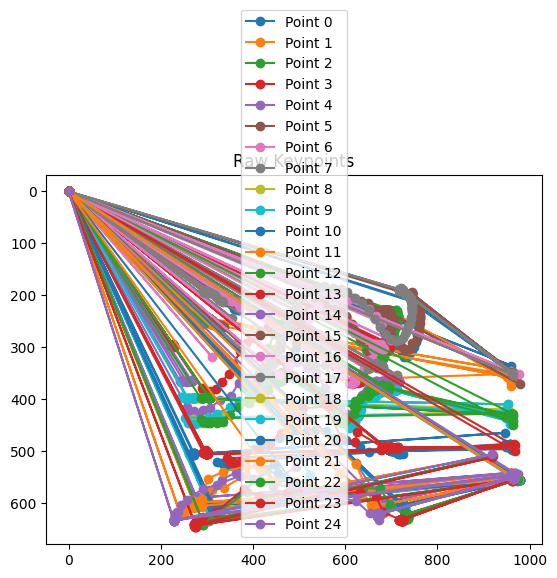

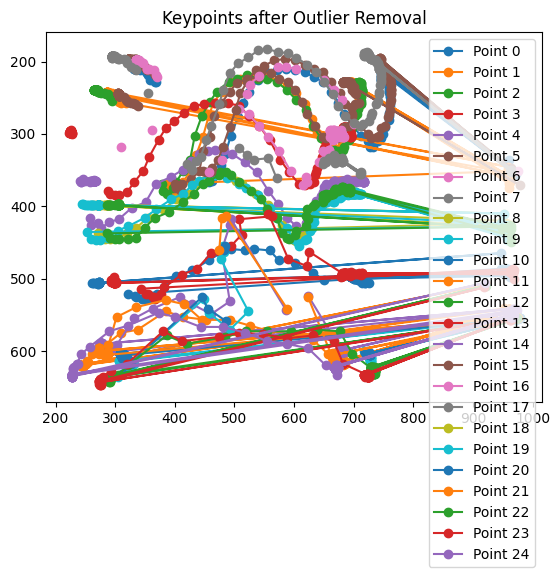

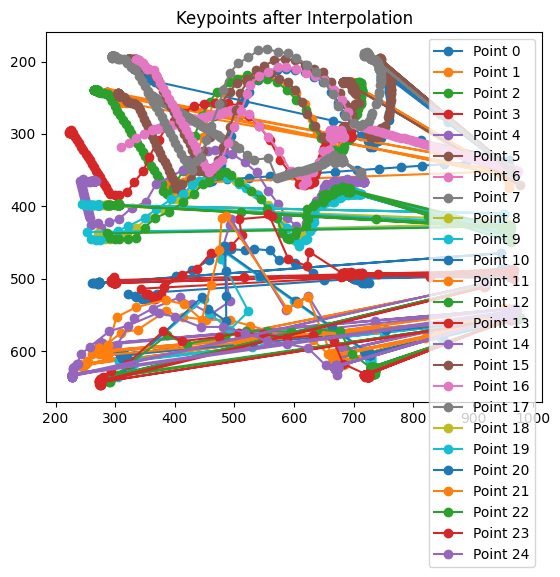

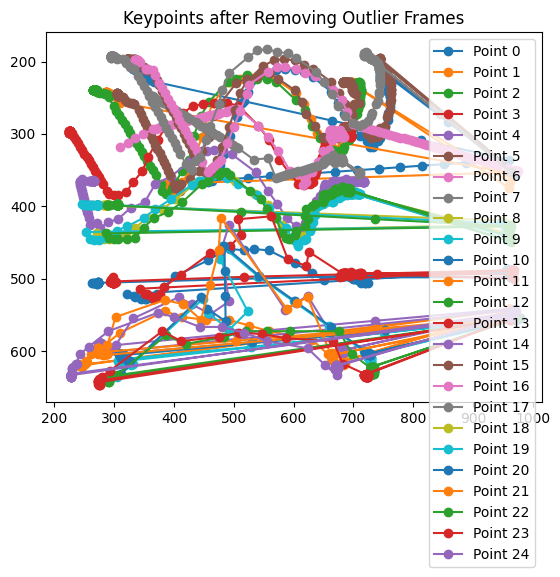

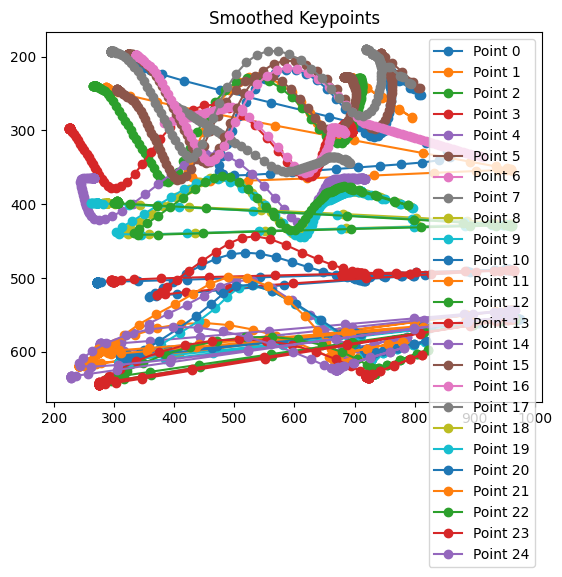

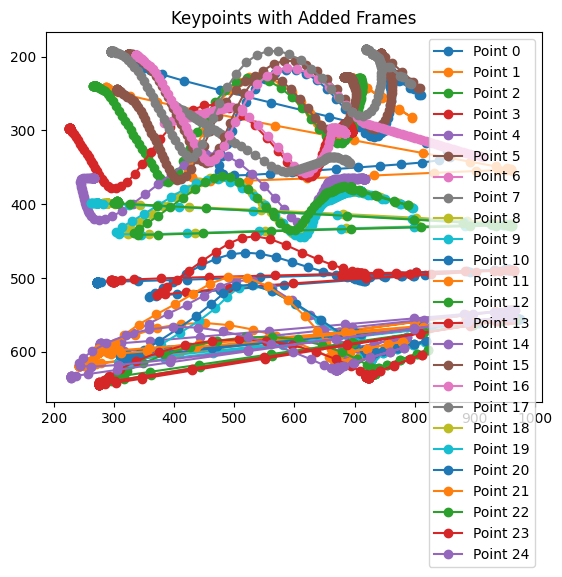

In [ ]:
#Preliminary code that cuts outliers, but the interpolating isn't great
#code below is a little better

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def load_keypoints_from_npy(input_folder):
    keypoints_list = []
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith(".npy"):
            file_path = os.path.join(input_folder, file_name)
            keypoints = np.load(file_path)
            keypoints_list.append(keypoints)
    return np.array(keypoints_list)

def remove_outliers(keypoints, threshold=3.0):
    zero_array = np.zeros_like(keypoints)
    valid_mask = np.all(keypoints != zero_array, axis=-1)
    mean = np.nanmean(keypoints[valid_mask], axis=0)
    std_dev = np.nanstd(keypoints[valid_mask], axis=0)
    valid_mask_all = np.all(np.abs(keypoints - mean) < threshold * std_dev, axis=-1)
    keypoints[~valid_mask_all] = np.nan
    keypoints[~valid_mask] = np.nan
    return keypoints

def interpolate_keypoints(keypoints):
    for i in range(keypoints.shape[1]):
        x_series = pd.Series(keypoints[:, i, 0])
        y_series = pd.Series(keypoints[:, i, 1])
        x_interp = x_series.interpolate(method='linear', limit_area='inside').to_numpy()
        y_interp = y_series.interpolate(method='linear', limit_area='inside').to_numpy()
        keypoints[:, i, 0] = x_interp
        keypoints[:, i, 1] = y_interp
    return keypoints

def smooth_keypoints(keypoints, sigma=2):
    smoothed_keypoints = np.empty_like(keypoints)
    for i in range(keypoints.shape[1]):
        x_smoothed = gaussian_filter1d(keypoints[:, i, 0], sigma=sigma, mode='nearest')
        y_smoothed = gaussian_filter1d(keypoints[:, i, 1], sigma=sigma, mode='nearest')
        smoothed_keypoints[:, i, 0] = x_smoothed
        smoothed_keypoints[:, i, 1] = y_smoothed
    return smoothed_keypoints

def calculate_frame_distances(keypoints):
    frame_distances = np.linalg.norm(keypoints[1:] - keypoints[:-1], axis=-1)
    return frame_distances

def plot_keypoints(keypoints, title):
    fig, ax = plt.subplots()
    for i in range(keypoints.shape[1]):
        ax.plot(keypoints[:, i, 0], keypoints[:, i, 1], marker='o', linestyle='-', label=f'Point {i}')
    ax.invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()

# Load keypoints
input_folder = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.66/Output_Arms_.66Max_T5'
keypoints = load_keypoints_from_npy(input_folder)

# Plot raw keypoints
plot_keypoints(keypoints, 'Raw Keypoints')

# Remove outliers
keypoints_cleaned = remove_outliers(keypoints)

# Plot keypoints after outlier removal
plot_keypoints(keypoints_cleaned, 'Keypoints after Outlier Removal')

# Interpolate missing data
keypoints_interpolated = interpolate_keypoints(keypoints_cleaned)

# Plot keypoints after interpolation
plot_keypoints(keypoints_interpolated, 'Keypoints after Interpolation')

# Calculate frame distances
frame_distances = calculate_frame_distances(keypoints_interpolated)

# Define a threshold for outlier frame removal
distance_threshold = 100  # Adjust as needed

# Find outlier frames
outlier_frames = np.where(frame_distances > distance_threshold)[0]

# Remove outlier frames from keypoints
keypoints_interpolated = np.delete(keypoints_interpolated, outlier_frames, axis=0)

# Plot keypoints after removing outlier frames
plot_keypoints(keypoints_interpolated, 'Keypoints after Removing Outlier Frames')

# Smooth the data
keypoints_smoothed = smooth_keypoints(keypoints_interpolated)

# Plot smoothed keypoints
plot_keypoints(keypoints_smoothed, 'Smoothed Keypoints')

# Calculate the total number of frames in the original data
total_original_frames = len(keypoints)

# Determine the number of frames to add back
frames_to_add = total_original_frames - len(keypoints_smoothed)

# Interpolate new frames to add back
new_frames = []
if frames_to_add > 0:
    for _ in range(frames_to_add):
        interpolated_frame = np.copy(keypoints_smoothed[-1])
        new_frames.append(interpolated_frame)

# Append the new frames to the processed keypoints
if new_frames:
    keypoints_smoothed_with_added_frames = np.concatenate((keypoints_smoothed, np.array(new_frames)))
else:
    keypoints_smoothed_with_added_frames = keypoints_smoothed

# Plot keypoints with added frames
plot_keypoints(keypoints_smoothed_with_added_frames, 'Keypoints with Added Frames')

# Save processed keypoints
output_folder = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.66/Output_Arms_.66Max_T5_Corrected'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save each frame's processed keypoints back to .npy files
for i, keypoints_frame in enumerate(keypoints_smoothed_with_added_frames):
    output_path = os.path.join(output_folder, f'frame_{i:04d}.npy')
    np.save(output_path, keypoints_frame)

# Optionally, save the entire processed keypoints array to a single file
# np.save(os.path.join(output_folder, 'keypoints_processed.npy'), keypoints_smoothed_with_added_frames)


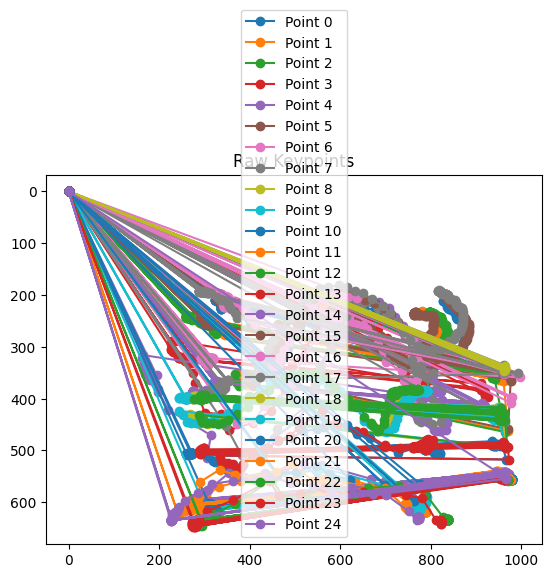

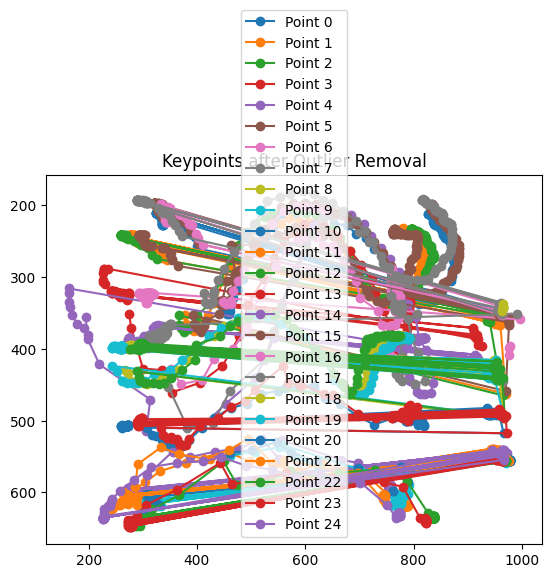

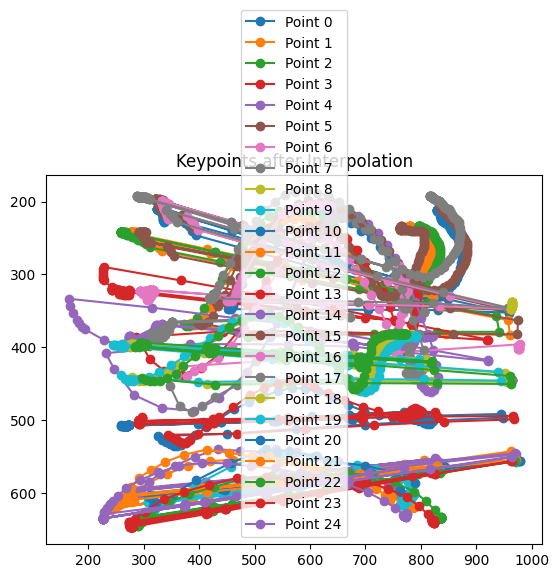

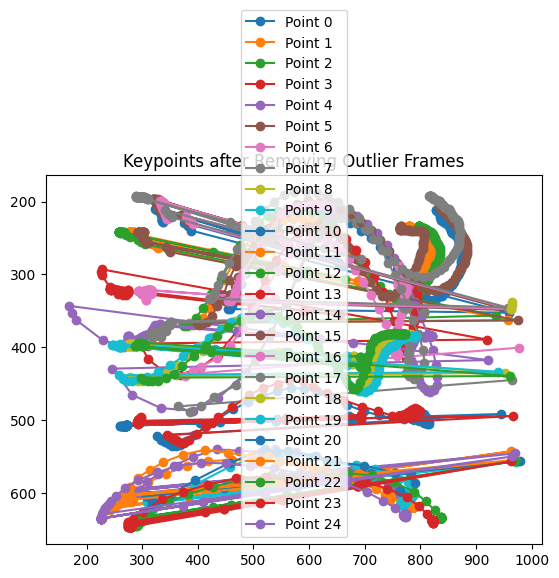

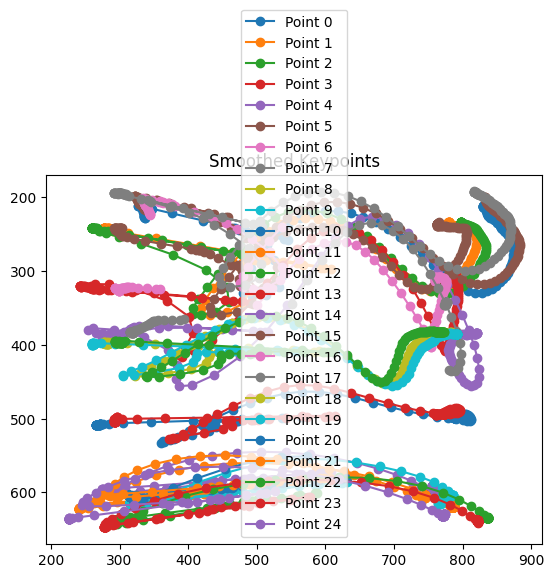

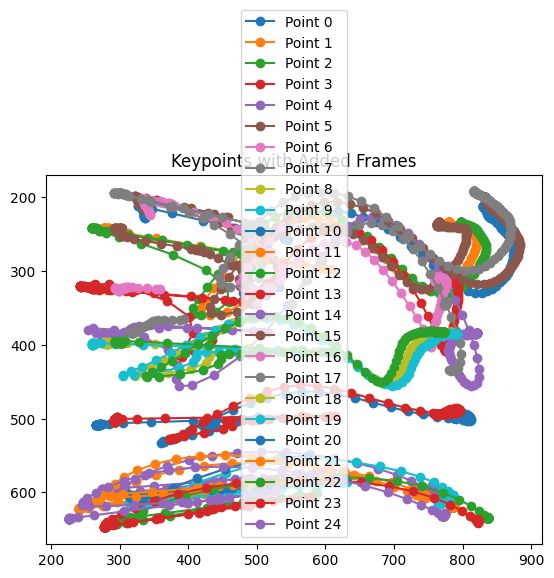

In [ ]:
# This code is decent. it smooths it well and doesn't have the weird mistakes that the above one has
# the only thing is that big outliers it smooths decently but not perfect. you see some noise if there are mistake points. but it is smoothed a lot.

# will need to revisit this to perfect at some point, but serves as a good baseline for preliminary modeling.

number = '5' # this # is the only thing that needs updating

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def load_keypoints_from_npy(input_folder):
    keypoints_list = []
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith(".npy"):
            file_path = os.path.join(input_folder, file_name)
            keypoints = np.load(file_path)
            keypoints_list.append(keypoints)
    return np.array(keypoints_list)

def remove_outliers(keypoints, threshold=3.0):
    zero_array = np.zeros_like(keypoints)
    valid_mask = np.all(keypoints != zero_array, axis=-1)
    mean = np.nanmean(keypoints[valid_mask], axis=0)
    std_dev = np.nanstd(keypoints[valid_mask], axis=0)
    valid_mask_all = np.all(np.abs(keypoints - mean) < threshold * std_dev, axis=-1)
    keypoints[~valid_mask_all] = np.nan
    keypoints[~valid_mask] = np.nan
    return keypoints

def interpolate_keypoints(keypoints):
    for i in range(keypoints.shape[1]):
        x_series = pd.Series(keypoints[:, i, 0])
        y_series = pd.Series(keypoints[:, i, 1])
        x_interp = x_series.interpolate(method='linear', limit_area='inside').to_numpy()
        y_interp = y_series.interpolate(method='linear', limit_area='inside').to_numpy()
        keypoints[:, i, 0] = x_interp
        keypoints[:, i, 1] = y_interp
    return keypoints

def smooth_keypoints(keypoints, sigma=2):
    smoothed_keypoints = np.empty_like(keypoints)
    for i in range(keypoints.shape[1]):
        x_smoothed = gaussian_filter1d(keypoints[:, i, 0], sigma=sigma, mode='nearest')
        y_smoothed = gaussian_filter1d(keypoints[:, i, 1], sigma=sigma, mode='nearest')
        smoothed_keypoints[:, i, 0] = x_smoothed
        smoothed_keypoints[:, i, 1] = y_smoothed
    return smoothed_keypoints

def calculate_frame_distances(keypoints):
    frame_distances = np.linalg.norm(keypoints[1:] - keypoints[:-1], axis=-1)
    return frame_distances

def plot_keypoints(keypoints, title):
    fig, ax = plt.subplots()
    for i in range(keypoints.shape[1]):
        ax.plot(keypoints[:, i, 0], keypoints[:, i, 1], marker='o', linestyle='-', label=f'Point {i}')
    ax.invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()

def interpolate_similar_points(keypoints, window=5):
    for i in range(keypoints.shape[1]):
        for j in range(2):  # Iterate over x and y coordinates
            series = pd.Series(keypoints[:, i, j])
            smoothed_series = series.rolling(window=window, min_periods=1, center=True).mean()
            series.interpolate(method='linear', limit_area='inside', inplace=True)
            keypoints[:, i, j] = smoothed_series.to_numpy()
    return keypoints

# Load keypoints
input_folder = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.66/Output_Arms_.66Max_T'+ number
keypoints = load_keypoints_from_npy(input_folder)

# Plot raw keypoints
plot_keypoints(keypoints, 'Raw Keypoints')

# Remove outliers
keypoints_cleaned = remove_outliers(keypoints)

# Plot keypoints after outlier removal
plot_keypoints(keypoints_cleaned, 'Keypoints after Outlier Removal')

# Interpolate missing data
keypoints_interpolated = interpolate_similar_points(keypoints_cleaned)

# Plot keypoints after interpolation
plot_keypoints(keypoints_interpolated, 'Keypoints after Interpolation')

# Calculate frame distances
frame_distances = calculate_frame_distances(keypoints_interpolated)

# Define a threshold for outlier frame removal
distance_threshold = 100  # Adjust as needed

# Find outlier frames
outlier_frames = np.where(frame_distances > distance_threshold)[0]

# Remove outlier frames from keypoints
keypoints_interpolated = np.delete(keypoints_interpolated, outlier_frames, axis=0)

# Plot keypoints after removing outlier frames
plot_keypoints(keypoints_interpolated, 'Keypoints after Removing Outlier Frames')

# Smooth the data
keypoints_smoothed = smooth_keypoints(keypoints_interpolated)

# Plot smoothed keypoints
plot_keypoints(keypoints_smoothed, 'Smoothed Keypoints')

# Calculate the total number of frames in the original data
total_original_frames = len(keypoints)

# Determine the number of frames to add back
frames_to_add = total_original_frames - len(keypoints_smoothed)

# Interpolate new frames to add back
new_frames = []
if frames_to_add > 0:
    for _ in range(frames_to_add):
        interpolated_frame = np.copy(keypoints_smoothed[-1])
        new_frames.append(interpolated_frame)

# Append the new frames to the processed keypoints
if new_frames:
    keypoints_smoothed_with_added_frames = np.concatenate((keypoints_smoothed, np.array(new_frames)))
else:
    keypoints_smoothed_with_added_frames = keypoints_smoothed

# Plot keypoints with added frames
plot_keypoints(keypoints_smoothed_with_added_frames, 'Keypoints with Added Frames')

# Save processed keypoints
output_folder = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.66/Output_Arms_.66Max_T' + number + '_Corrected'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save each frame's processed keypoints back to .npy files
for i, keypoints_frame in enumerate(keypoints_smoothed_with_added_frames):
    output_path = os.path.join(output_folder, f'frame_{i:04d}.npy')
    np.save(output_path, keypoints_frame)

# Optionally, save the entire processed keypoints array to a single file
# np.save(os.path.join(output_folder, 'keypoints_processed.npy'), keypoints_smoothed_with_added_frames)


In [ ]:
import ffmpeg

# Input video paths
input_video1 = 'testARMSReference.mp4'
input_video2 = 'keypoints_animation5.mp4'

# Output video path
output_video = 'combined_animation.mp4'

# Combine videos side by side
ffmpeg.concat(
    ffmpeg.input(input_video1),
    ffmpeg.input(input_video2)
).output(
    output_video,
    filter_complex="[0:v][1:v]hstack=inputs=2"
).run()


(None, None)

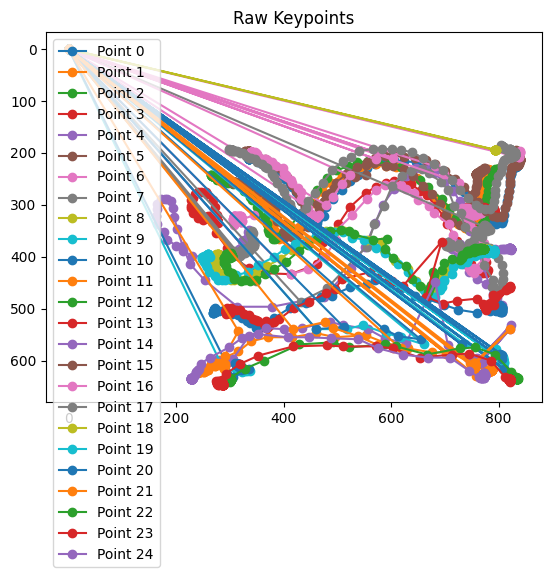

keypoints shape: (165, 25, 3)
frame_distances shape: (164, 25)
valid_frames shape: (165,)


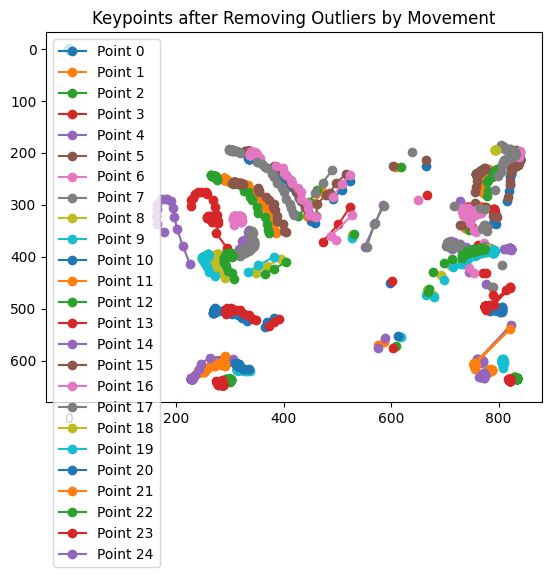

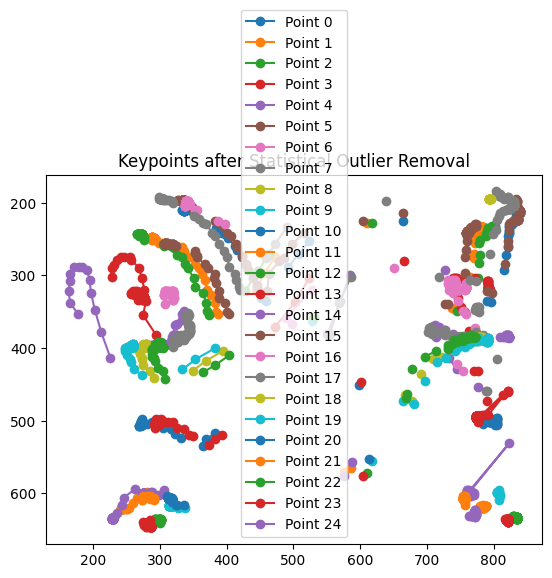

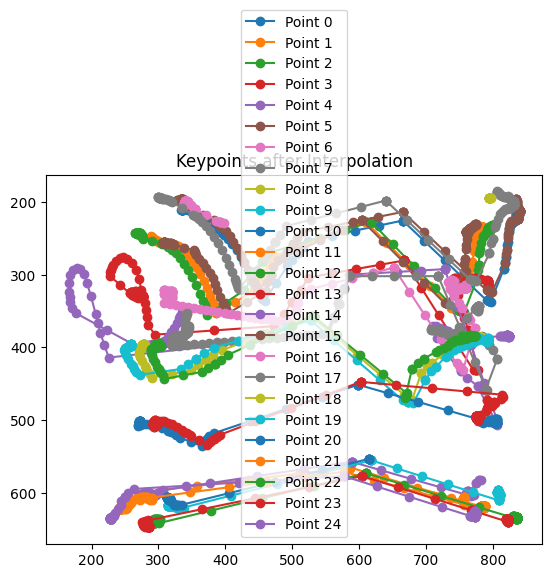

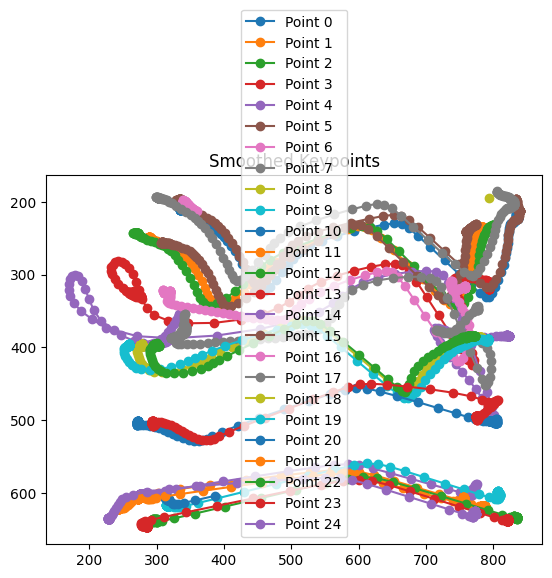

In [ ]:
# THIS CODE IS WAY BETTER FOR CUTTING THE BAD OUTLIERS


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

number = '1'  # Update this number as needed

def load_keypoints_from_npy(input_folder):
    keypoints_list = []
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith(".npy"):
            file_path = os.path.join(input_folder, file_name)
            keypoints = np.load(file_path)
            keypoints_list.append(keypoints)
    return np.array(keypoints_list)

def remove_outliers_by_movement(keypoints, distance_threshold=100):
    keypoints_diff = np.diff(keypoints, axis=0)
    frame_distances = np.linalg.norm(keypoints_diff, axis=-1)
    valid_frames = np.all(frame_distances < distance_threshold, axis=-1)
    valid_frames = np.insert(valid_frames, 0, True)  # Assume the first frame is always valid

    # Debugging information
    print(f"keypoints shape: {keypoints.shape}")
    print(f"frame_distances shape: {frame_distances.shape}")
    print(f"valid_frames shape: {valid_frames.shape}")

    if len(valid_frames) != len(keypoints):
        raise ValueError("The length of valid_frames does not match the number of keypoints frames.")

    keypoints[~valid_frames] = np.nan
    return keypoints

def remove_outliers_by_statistics(keypoints, threshold=3.0):
    zero_array = np.zeros_like(keypoints)
    valid_mask = np.all(keypoints != zero_array, axis=-1)
    mean = np.nanmean(keypoints[valid_mask], axis=0)
    std_dev = np.nanstd(keypoints[valid_mask], axis=0)
    valid_mask_all = np.all(np.abs(keypoints - mean) < threshold * std_dev, axis=-1)
    keypoints[~valid_mask_all] = np.nan
    keypoints[~valid_mask] = np.nan
    return keypoints

def interpolate_keypoints(keypoints):
    for i in range(keypoints.shape[1]):
        for j in range(2):  # Iterate over x and y coordinates
            series = pd.Series(keypoints[:, i, j])
            interpolated_series = series.interpolate(method='linear', limit_area='inside').to_numpy()
            keypoints[:, i, j] = interpolated_series
    return keypoints

def smooth_keypoints(keypoints, sigma=2):
    smoothed_keypoints = np.empty_like(keypoints)
    for i in range(keypoints.shape[1]):
        smoothed_keypoints[:, i, 0] = gaussian_filter1d(keypoints[:, i, 0], sigma=sigma, mode='nearest')
        smoothed_keypoints[:, i, 1] = gaussian_filter1d(keypoints[:, i, 1], sigma=sigma, mode='nearest')
    return smoothed_keypoints

def plot_keypoints(keypoints, title):
    fig, ax = plt.subplots()
    for i in range(keypoints.shape[1]):
        ax.plot(keypoints[:, i, 0], keypoints[:, i, 1], marker='o', linestyle='-', label=f'Point {i}')
    ax.invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()

def interpolate_similar_points(keypoints, window=5):
    for i in range(keypoints.shape[1]):
        for j in range(2):  # Iterate over x and y coordinates
            series = pd.Series(keypoints[:, i, j])
            smoothed_series = series.rolling(window=window, min_periods=1, center=True).mean()
            keypoints[:, i, j] = smoothed_series.interpolate(method='linear', limit_area='inside').to_numpy()
    return keypoints

def process_keypoints(input_folder, distance_threshold=100, outlier_threshold=3.0):
    # Load keypoints
    keypoints = load_keypoints_from_npy(input_folder)
    plot_keypoints(keypoints, 'Raw Keypoints')

    # Remove outliers based on movement
    keypoints = remove_outliers_by_movement(keypoints, distance_threshold)
    plot_keypoints(keypoints, 'Keypoints after Removing Outliers by Movement')

    # Remove outliers based on statistical analysis
    keypoints_cleaned = remove_outliers_by_statistics(keypoints, outlier_threshold)
    plot_keypoints(keypoints_cleaned, 'Keypoints after Statistical Outlier Removal')

    # Interpolate missing data
    keypoints_interpolated = interpolate_similar_points(keypoints_cleaned)
    plot_keypoints(keypoints_interpolated, 'Keypoints after Interpolation')

    # Smooth the data
    keypoints_smoothed = smooth_keypoints(keypoints_interpolated)
    plot_keypoints(keypoints_smoothed, 'Smoothed Keypoints')

    return keypoints_smoothed

def save_keypoints(output_folder, keypoints):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, keypoints_frame in enumerate(keypoints):
        output_path = os.path.join(output_folder, f'frame_{i:04d}.npy')
        np.save(output_path, keypoints_frame)

# Define input and output folders
input_folder = f'/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.66/Output_Arms_.66Max_T{number}'
output_folder = f'/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.66/Output_Arms_.66Max_T{number}_Corrected'

# Process and save keypoints
keypoints_processed = process_keypoints(input_folder)
save_keypoints(output_folder, keypoints_processed)


In [ ]:
import cv2

def get_video_framerate(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Check if the video was opened successfully
    if not video.isOpened():
        print("Error: Could not open video.")
        return None

    # Get the framerate of the video
    framerate = video.get(cv2.CAP_PROP_FPS)

    # Release the video capture object
    video.release()

    return framerate

# Example usage
video_path = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/AllVideoFiles/OriginalVideos/Arms_Max_T2.mp4'
framerate = get_video_framerate(video_path)

if framerate is not None:
    print(f"The framerate of the video is: {framerate} frames per second")
else:
    print("Could not determine the framerate of the video.")


Error: Could not open video.
Could not determine the framerate of the video.


In [ ]:
import cv2

def get_video_framerate(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Check if the video was opened successfully
    if not video.isOpened():
        print("Error: Could not open video.")
        return None

    # Get the framerate of the video
    framerate = video.get(cv2.CAP_PROP_FPS)

    # Release the video capture object
    video.release()

    return framerate

# Example usage
video_path = '/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/AllVideoFiles/OriginalVideos/Max/Arms_Max_T2.MP4'
framerate = get_video_framerate(video_path)

if framerate is not None:
    print(f"The framerate of the video is: {framerate} frames per second")
else:
    print("Could not determine the framerate of the video.")


The framerate of the video is: 29.97002997002997 frames per second


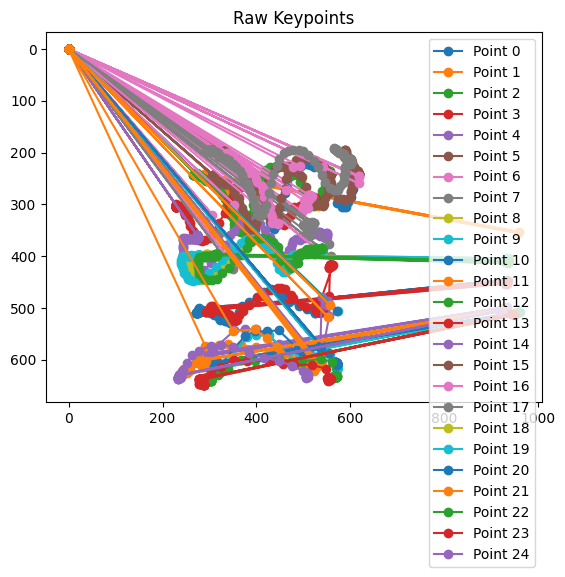

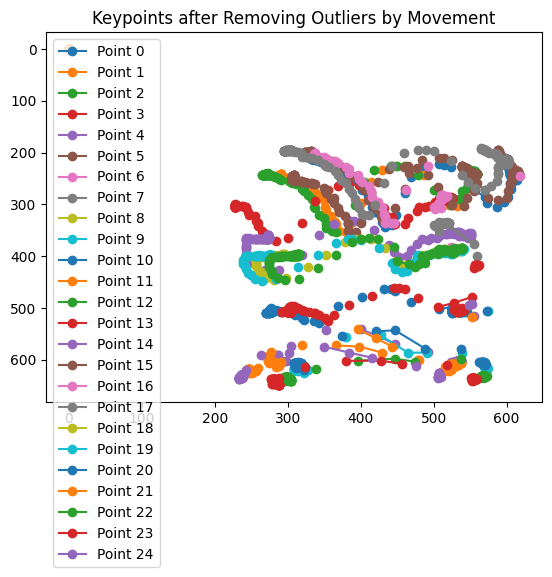

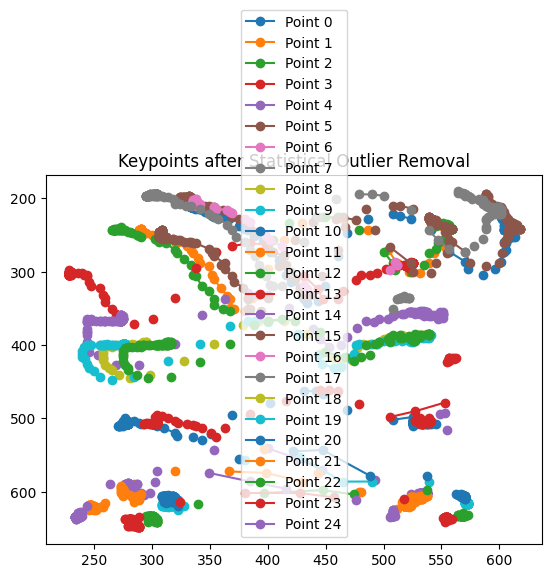

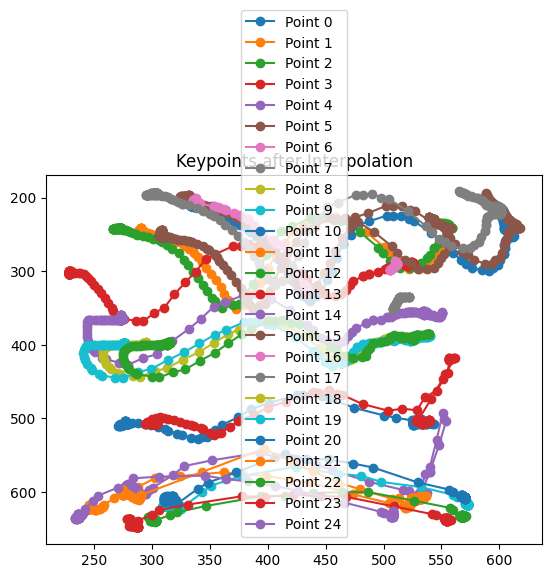

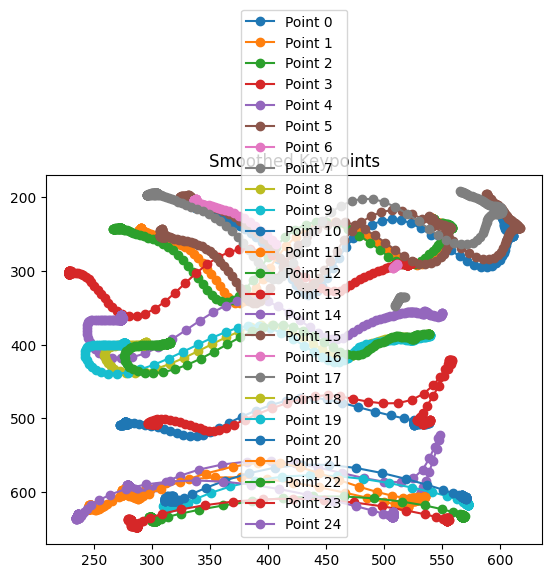

In [ ]:
# THIS CODE IS WAY BETTER FOR CUTTING THE BAD OUTLIERS

# it cuts the invalid frames of mistakes decently by recognizing frames that only have an arm or legs or smthing like that


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

number = '5'  # Update this number as needed

def load_keypoints_from_npy(input_folder):
    keypoints_list = []
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith(".npy"):
            file_path = os.path.join(input_folder, file_name)
            keypoints = np.load(file_path)
            keypoints_list.append(keypoints)
    return np.array(keypoints_list)

def remove_outliers_by_movement(keypoints, distance_threshold=100):
    valid_frames = np.ones(keypoints.shape[0], dtype=bool)  # Start by assuming all frames are valid
    for i in range(1, keypoints.shape[0]):
        if not valid_frames[i-1]:  # Skip if the previous frame was invalid
            continue
        keypoints_diff = np.linalg.norm(keypoints[i] - keypoints[i-1], axis=-1)
        if np.any(keypoints_diff > distance_threshold):
            valid_frames[i] = False

    keypoints[~valid_frames] = np.nan

    # Check if more than half of the keypoints in each frame are zero
    zero_count = np.sum(keypoints == 0, axis=(1, 2))
    valid_frames[zero_count > (keypoints.shape[1] * keypoints.shape[2] / 2)] = False
    keypoints[~valid_frames] = np.nan

    return keypoints


def remove_outliers_by_statistics(keypoints, threshold=3.0):
    zero_array = np.zeros_like(keypoints)
    valid_mask = np.all(keypoints != zero_array, axis=-1)
    mean = np.nanmean(keypoints[valid_mask], axis=0)
    std_dev = np.nanstd(keypoints[valid_mask], axis=0)
    valid_mask_all = np.all(np.abs(keypoints - mean) < threshold * std_dev, axis=-1)
    keypoints[~valid_mask_all] = np.nan
    keypoints[~valid_mask] = np.nan
    return keypoints

def interpolate_keypoints(keypoints):
    for i in range(keypoints.shape[1]):
        for j in range(2):  # Iterate over x and y coordinates
            series = pd.Series(keypoints[:, i, j])
            interpolated_series = series.interpolate(method='linear', limit_area='inside').to_numpy()
            keypoints[:, i, j] = interpolated_series
    return keypoints

def smooth_keypoints(keypoints, sigma=2):
    smoothed_keypoints = np.empty_like(keypoints)
    for i in range(keypoints.shape[1]):
        smoothed_keypoints[:, i, 0] = gaussian_filter1d(keypoints[:, i, 0], sigma=sigma, mode='nearest')
        smoothed_keypoints[:, i, 1] = gaussian_filter1d(keypoints[:, i, 1], sigma=sigma, mode='nearest')
    return smoothed_keypoints

def plot_keypoints(keypoints, title):
    fig, ax = plt.subplots()
    for i in range(keypoints.shape[1]):
        ax.plot(keypoints[:, i, 0], keypoints[:, i, 1], marker='o', linestyle='-', label=f'Point {i}')
    ax.invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()

def interpolate_similar_points(keypoints, window=5):
    for i in range(keypoints.shape[1]):
        for j in range(2):  # Iterate over x and y coordinates
            series = pd.Series(keypoints[:, i, j])
            smoothed_series = series.rolling(window=window, min_periods=1, center=True).mean()
            keypoints[:, i, j] = smoothed_series.interpolate(method='linear', limit_area='inside').to_numpy()
    return keypoints

def process_keypoints(input_folder, distance_threshold=100, outlier_threshold=3.0):
    # Load keypoints
    keypoints = load_keypoints_from_npy(input_folder)
    plot_keypoints(keypoints, 'Raw Keypoints')

    # Remove outliers based on movement
    keypoints = remove_outliers_by_movement(keypoints, distance_threshold)
    plot_keypoints(keypoints, 'Keypoints after Removing Outliers by Movement')

    # Remove outliers based on statistical analysis
    keypoints_cleaned = remove_outliers_by_statistics(keypoints, outlier_threshold)
    plot_keypoints(keypoints_cleaned, 'Keypoints after Statistical Outlier Removal')

    # Interpolate missing data
    keypoints_interpolated = interpolate_similar_points(keypoints_cleaned)
    plot_keypoints(keypoints_interpolated, 'Keypoints after Interpolation')

    # Smooth the data
    keypoints_smoothed = smooth_keypoints(keypoints_interpolated)
    plot_keypoints(keypoints_smoothed, 'Smoothed Keypoints')

    return keypoints_smoothed

def save_keypoints(output_folder, keypoints):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, keypoints_frame in enumerate(keypoints):
        output_path = os.path.join(output_folder, f'frame_{i:04d}.npy')
        np.save(output_path, keypoints_frame)

# Define input and output folders
input_folder = f'/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.33/Output_NoArms_.33Max_T{number}'
output_folder = f'/content/drive/My Drive/SLJ/COSC/Preliminary SLJ Trials (OpenPose)/NEW TRIALS/Data/NPYs/.33/Output_NoArms_.33Max_T{number}_Corrected'

# Process and save keypoints
keypoints_processed = process_keypoints(input_folder)
save_keypoints(output_folder, keypoints_processed)
